# Client's segmentation

Using the Brazilian E-Commerce Public Dataset by Olist (https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce), we try here to perform a segmentation of Olist's clients. We will also assess the evolution of the pertinence of the said segmentation through time and set a maintenance contract.

## Data cleaning

Here we merge the diferent datasets and extract the different features. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import geopy.distance
import os

    

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

#load csv files

PATH = "F:\Work\OpenClassroomML\Projet4\data"

customerdf = pd.read_csv(os.path.join(PATH, "olist_customers_dataset.csv"),
                         encoding = 'utf8',
                         sep = ',',
                         low_memory = False)

geolocationdf = pd.read_csv(os.path.join(PATH, "olist_geolocation_dataset.csv"),
                            encoding = 'utf8',
                            sep = ',',
                            low_memory = False)

itemsdf = pd.read_csv(os.path.join(PATH, "olist_order_items_dataset.csv"),
                      encoding = 'utf8',
                      sep = ',',
                      low_memory = False)

paymentsdf = pd.read_csv(os.path.join(PATH, "olist_order_payments_dataset.csv"),
                         encoding = 'utf8',
                         sep = ',',
                         low_memory = False)

reviewsdf = pd.read_csv(os.path.join(PATH, "olist_order_reviews_dataset.csv"),
                        encoding = 'utf8',
                        sep = ',',
                        low_memory = False)

ordersdf = pd.read_csv(os.path.join(PATH, "olist_orders_dataset.csv"),
                       encoding = 'utf8',
                       sep = ',',
                       low_memory = False)

productsdf = pd.read_csv(os.path.join(PATH, "olist_products_dataset.csv"),
                         encoding = 'utf8',
                         sep = ',',
                         low_memory = False)

sellersdf = pd.read_csv(os.path.join(PATH, "olist_sellers_dataset.csv"),
                        encoding = 'utf8',
                        sep = ',',
                        low_memory = False)

translationdf = pd.read_csv(os.path.join(PATH, "product_category_name_translation.csv"),
                            encoding = 'utf8',
                            sep = ',',
                            low_memory = False)

Checking for duplicates :

In [2]:
productsdf.duplicated(subset="product_id").sum()

0

In [3]:
sellersdf.duplicated(subset="seller_id").sum()

0

In [4]:
ordersdf.duplicated(subset="order_id").sum()

0

In [5]:
paymentsdf.duplicated(subset="order_id").sum()

4446

In [6]:
reviewsdf.duplicated(subset="order_id").sum()

551

In [7]:
translationdf.duplicated(subset="product_category_name").sum()

0

In [8]:
itemsdf.duplicated(subset="order_id").sum()

13984

In [9]:
customerdf.duplicated(subset="customer_id").sum()

0

In [10]:
geolocationdf.duplicated(subset="geolocation_zip_code_prefix").sum() 

981148

In [11]:
#dropping duplicates as geolocationdf is supposed to be a dictionary
geolocationdf = geolocationdf.drop_duplicates(subset=['geolocation_zip_code_prefix']).reset_index(drop=True)

In [12]:
itemsdf.duplicated(subset="product_id").sum()

79699

In [13]:
itemsdf.duplicated(subset="seller_id").sum()

109555

Before merging we need to enginner paymentsdf,reviewsdf and itemsdf to lift the degeneracy of their merging keys

Enginneering paymentsdf :

In [14]:
paymentsdf

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [15]:
#encoding payment type
paymentsdf = paymentsdf.dropna(subset=['payment_type']) #3 entry dropped
paymentsdf.loc[(paymentsdf.payment_type == 'not_defined'),'payment_type'] = 'payment_not_defined' #to look good after encoding
paymentsdf.loc[(paymentsdf.payment_type == 'boleto'),'payment_type'] = 'cash'
# creating instance of one-hot-encoder
ohe = OneHotEncoder()
transformed = ohe.fit_transform(paymentsdf[["payment_type"]])
#adding encoded columns to dataframe
paymentsdf[ohe.categories_[0]] = transformed.toarray()

#multiplying by money amount
paymentsdf[ohe.categories_[0]] = paymentsdf[ohe.categories_[0]].mul(paymentsdf["payment_value"], axis = 0)

#Group data on order_id
paymentsdf = paymentsdf.groupby(['order_id']).agg(
    payment_sequential= ('payment_sequential', 'max'),
    cash_payment= ('cash', 'sum'),
    credit_card_payment= ('credit_card', 'sum'),
    debit_card_payment= ('debit_card', 'sum'),
    voucher_payment= ('voucher', 'sum'),
    undefined_payment= ('payment_not_defined', 'sum'),
    total_payment= ('payment_value', 'sum')
    )



Enginneering reviewsdf :

In [16]:
reviewsdf

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [17]:
#extracting customer response time
reviewsdf["review_answer_time"] = ((pd.to_datetime(reviewsdf['review_answer_timestamp']) 
                                    - pd.to_datetime(reviewsdf['review_creation_date']))).dt.total_seconds()
reviewsdf.drop(columns=['review_answer_timestamp', 'review_creation_date',"review_comment_title"])

#Dopping non rated orders
reviewsdf = reviewsdf.dropna(subset=['review_score'])
#encoding review_comment_message
reviewsdf.loc[reviewsdf["review_comment_message"].notnull(), "review_comment_message"] = 1
reviewsdf.loc[reviewsdf["review_comment_message"].isnull(), "review_comment_message"] = 0

#Group data on order_id
reviewsdf = reviewsdf.groupby(['order_id']).agg(
    mean_review_score= ('review_score', 'mean'),
    review_comment_message_number= ('review_comment_message', 'sum'),
    mean_review_answer_time= ('review_answer_time', 'mean')
    )


In [18]:
#merge auxiliary datasets
tempdf1 = sellersdf.merge(geolocationdf,
                          how = 'left',
                          left_on = 'seller_zip_code_prefix',
                          right_on = 'geolocation_zip_code_prefix')

tempdf1 = tempdf1.rename(columns = {'geolocation_lat':'seller_geolocation_lat',
                                    'geolocation_lng':'seller_geolocation_lng',
                                    'geolocation_city':'seller_geolocation_city',
                                    'geolocation_state':'seller_geolocation_state'})

tempdf2 = itemsdf.merge(productsdf,how = 'left', on = 'product_id')
tempdf2 = tempdf2.merge(tempdf1,how = 'left', on = 'seller_id')
tempdf2 = tempdf2.merge(translationdf,how = 'left', on = 'product_category_name')

tempdf3 = customerdf.merge(geolocationdf,
                           how ='left',
                           left_on = 'customer_zip_code_prefix',
                           right_on = 'geolocation_zip_code_prefix')

tempdf3 = tempdf3.rename(columns = {'geolocation_lat':'customer_geolocation_lat',
                                    'geolocation_lng':'customer_geolocation_lng',
                                    'geolocation_city':'customer_geolocation_city',
                                    'geolocation_state':'customer_geolocation_state'})


Enginneering tempdf2 (itemsdf) :

In [19]:
tempdf2

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,seller_geolocation_lat,seller_geolocation_lng,seller_geolocation_city,seller_geolocation_state,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,27277.0,-22.498183,-44.123614,volta redonda,RJ,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471,sao paulo,SP,3471.0,-23.566258,-46.518417,sao paulo,SP,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564,borda da mata,MG,37564.0,-22.264094,-46.158564,borda da mata,MG,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403,franca,SP,14403.0,-20.548228,-47.395897,franca,SP,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900,loanda,PR,87900.0,-22.931427,-53.133759,loanda,PR,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303,itajai,SC,88303.0,-26.912429,-48.677381,itajai,SC,housewares
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,informatica_acessorios,31.0,232.0,1.0,8950.0,45.0,26.0,38.0,1206,sao paulo,SP,1206.0,-23.535536,-46.643052,sao paulo,SP,computers_accessories
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,esporte_lazer,43.0,869.0,1.0,967.0,21.0,24.0,19.0,80610,curitiba,PR,80610.0,-25.469214,-49.293935,curitiba,PR,sports_leisure
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,informatica_acessorios,56.0,1306.0,1.0,100.0,20.0,20.0,20.0,4733,sao paulo,SP,4733.0,-23.636657,-46.694780,são paulo,SP,computers_accessories


In [20]:
tempdf2.duplicated(subset = ["order_id"]).sum()

13984

In [21]:
tempdf2.duplicated(subset = ["order_id","order_item_id"]).sum()

0

In [22]:
#Dropping pottential null entries
tempdf2 = tempdf2.dropna(subset = ["product_category_name_english",
                                   "seller_city",
                                   "seller_state"])

#Group data on order_id key
tempdf2 = tempdf2.groupby(['order_id']).agg(
    order_item_number = ('order_item_id', 'max'),
    price_total = ('price', 'sum'),
    freight_value_total = ('freight_value', 'sum'),
    product_category_name_mostfrequent = ('product_category_name_english', lambda x: x.value_counts().index.tolist()[0]),
    seller_city_mostfrequent = ('seller_city', lambda x: x.value_counts().index.tolist()[0]),
    seller_state_mostfrequent = ('seller_state', lambda x: x.value_counts().index.tolist()[0]),
    seller_geolocation_lat_mean = ('seller_geolocation_lat', 'mean'),
    seller_geolocation_lng_mean = ('seller_geolocation_lat', 'mean')
    )


In [23]:
tempdf2

,order_item_number,price_total,freight_value_total,product_category_name_mostfrequent,seller_city_mostfrequent,seller_state_mostfrequent,seller_geolocation_lat_mean,seller_geolocation_lng_mean
order_id,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,58.90,13.29,cool_stuff,volta redonda,SP,-22.498183,-22.498183
00018f77f2f0320c557190d7a144bdd3,1,239.90,19.93,pet_shop,sao paulo,SP,-23.566258,-23.566258
000229ec398224ef6ca0657da4fc703e,1,199.00,17.87,furniture_decor,borda da mata,MG,-22.264094,-22.264094
00024acbcdf0a6daa1e931b038114c75,1,12.99,12.79,perfumery,franca,SP,-20.548228,-20.548228
00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,18.14,garden_tools,loanda,PR,-22.931427,-22.931427
...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,299.99,43.41,housewares,itajai,SC,-26.912429,-26.912429
fffcd46ef2263f404302a634eb57f7eb,1,350.00,36.53,computers_accessories,sao paulo,SP,-23.535536,-23.535536
fffce4705a9662cd70adb13d4a31832d,1,99.90,16.95,sports_leisure,curitiba,PR,-25.469214,-25.469214


In [24]:
#Merging main dataset
df = pd.DataFrame()
df = ordersdf.merge(tempdf2,how = 'left', on = 'order_id')
df = df.merge(paymentsdf,how = 'left', on = 'order_id')
df = df.merge(reviewsdf,how = 'left', on = 'order_id')
df = df.merge(tempdf3,how = 'left', on = 'customer_id')
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_number,price_total,freight_value_total,product_category_name_mostfrequent,seller_city_mostfrequent,seller_state_mostfrequent,seller_geolocation_lat_mean,seller_geolocation_lng_mean,payment_sequential,cash_payment,credit_card_payment,debit_card_payment,voucher_payment,undefined_payment,total_payment,mean_review_score,review_comment_message_number,mean_review_answer_time,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,customer_geolocation_lat,customer_geolocation_lng,customer_geolocation_city,customer_geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,29.99,8.72,housewares,maua,SP,-23.680114,-23.680114,3.0,0.00,18.12,0.00,20.59,0.0,38.71,4.0,1,99828.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3149.0,-23.574809,-46.587471,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,118.70,22.76,perfumery,belo horizonte,SP,-19.810119,-19.810119,1.0,141.46,0.00,0.00,0.00,0.0,141.46,4.0,1,67070.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,47813.0,-12.169860,-44.988369,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,159.90,19.22,auto,guariba,SP,-21.362358,-21.362358,1.0,0.00,179.12,0.00,0.00,0.0,179.12,5.0,0,414478.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,75265.0,-16.746337,-48.514624,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,45.00,27.20,pet_shop,belo horizonte,MG,-19.840168,-19.840168,1.0,0.00,72.20,0.00,0.00,0.0,72.20,5.0,1,242518.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,59296.0,-5.767733,-35.275467,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,19.90,8.72,stationery,mogi das cruzes,SP,-23.551707,-23.551707,1.0,0.00,28.62,0.00,0.00,0.0,28.62,5.0,0,133371.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,9195.0,-23.675037,-46.524784,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,1.0,72.00,13.08,health_beauty,braganca paulista,SP,-22.957505,-22.957505,1.0,0.00,85.08,0.00,0.00,0.0,85.08,5.0,0,126128.0,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,12209.0,-23.178732,-45.889711,são josé dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,174.90,20.10,baby,tupa,SP,-21.935321,-21.935321,1.0,0.00,195.00,0.00,0.00,0.0,195.00,4.0,1,150601.0,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,11722.0,-24.001467,-46.446355,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,205.99,65.02,home_appliances_2,sao paulo,SP,-23.551013,-23.551013,1.0,0.00,271.01,0.00,0.00,0.0,271.01,5.0,1,83457.0,737520a9aad80b3fbbdad19b66b37b30,45

In [25]:
df["customer_unique_id"].nunique()

96096

In [26]:
df.isnull().sum()

order_id                                 0
customer_id                              0
order_status                             0
order_purchase_timestamp                 0
order_approved_at                      160
order_delivered_carrier_date          1783
order_delivered_customer_date         2965
order_estimated_delivery_date            0
order_item_number                     2185
price_total                           2185
freight_value_total                   2185
product_category_name_mostfrequent    2185
seller_city_mostfrequent              2185
seller_state_mostfrequent             2185
seller_geolocation_lat_mean           2400
seller_geolocation_lng_mean           2400
payment_sequential                       1
cash_payment                             1
credit_card_payment                      1
debit_card_payment                       1
voucher_payment                          1
undefined_payment                        1
total_payment                            1
mean_review

In [27]:
df.describe()

,order_item_number,price_total,freight_value_total,seller_geolocation_lat_mean,seller_geolocation_lng_mean,payment_sequential,cash_payment,credit_card_payment,debit_card_payment,voucher_payment,undefined_payment,total_payment,mean_review_score,mean_review_answer_time,customer_zip_code_prefix,geolocation_zip_code_prefix,customer_geolocation_lat,customer_geolocation_lng
count,97256.000000,97256.000000,97256.000000,97041.000000,97041.000000,99440.000000,99440.000000,99440.000000,99440.000000,99440.000000,99440.0,99440.000000,98673.000000,9.867300e+04,99441.000000,99163.000000,99163.000000,99163.000000
mean,1.141966,137.848502,22.860249,-22.793510,-22.793510,1.045515,28.855202,126.127154,2.192174,3.815737,0.0,160.990267,4.086793,2.721162e+05,35137.474583,35057.887176,-21.192930,-46.176190
std,0.539403,210.515926,21.700642,2.752270,2.752270,0.382177,111.479625,207.840370,35.158023,34.110992,0.0,221.951257,1.346274,8.551999e+05,29797.938996,29784.314664,5.620584,4.066202
min,1.000000,0.850000,0.000000,-36.605374,-36.605374,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,7.709000e+03,1003.000000,1003.000000,-36.605374,-72.666706
25%,1.000000,45.900000,13.860000,-23.615021,-23.615021,1.000000,0.000000,24.097500,0.000000,0.000000,0.0,62.010000,4.000000,8.684300e+04,11347.000000,11320.000000,-23.588296,-48.096342
50%,1.000000,86.800000,17.210000,-23.418486,-23.418486,1.000000,0.000000,77.500000,0.000000,0.000000,0.0,105.290000,5.000000,1.449570e+05,24416.000000,24350.000000,-22.926905,-46.630764
75%,1.000000,149.900000,24.110000,-21.766477,-21.766477,1.000000,0.000000,154.050000,0.000000,0.000000,0.0,176.970000,5.000000,2.679850e+05,58900.000000,58406.500000,-20.146615,-43.602775
max,21.000000,13440.000000,1794.960000,-2.546079,-2.546079,29.000000,7274.880000,13664.080000,4445.500000,3184.340000,0.0,13664.080000,5.000000,4.481561e+07,99990.000000,99990.000000,42.184003,-8.577855


In [28]:
df.duplicated(subset = "order_id").sum()

0

In [29]:
df.duplicated(subset = "customer_unique_id").sum()

3345

In [30]:
df['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [31]:
#Dopping non deliverded orders
df = df.drop(df.loc[df.order_status != "delivered"].index)

Extracting some interesting features as Recency, Frequency, Monetary, delivery time, seller-customer distance ...

In [32]:
#extracting delivery time
df["delivery_time"] = ((pd.to_datetime(df['order_delivered_customer_date'])
                        - pd.to_datetime(df['order_purchase_timestamp']))).dt.total_seconds()

#extracting recency
minrecencydatetime  = pd.to_datetime(df['order_purchase_timestamp']).min()
df["recency"] = (pd.to_datetime(df['order_purchase_timestamp'])-minrecencydatetime).dt.total_seconds()

#extracting distance between seller and customer (assuming spherical earth)
df = df.dropna(subset = ['seller_geolocation_lat_mean',
                         'seller_geolocation_lng_mean',
                         'customer_geolocation_lat',
                         'customer_geolocation_lng'])

df['seller_coordinates'] = list(zip(df.seller_geolocation_lat_mean, df.seller_geolocation_lng_mean))
df['customer_coordinates'] = list(zip(df.customer_geolocation_lat, df.customer_geolocation_lng))

for index, row in df.iterrows():
    df.loc[index,"seller_customer_distance"] = geopy.distance.geodesic(row['seller_coordinates'],
                                                                       row['customer_coordinates']).m

In [33]:
print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  94657  individuals and  40  variables.


In [34]:
#Dropping null values
intcol = ['delivery_time',
          'mean_review_answer_time',
          'review_comment_message_number',
          'payment_sequential',
          'cash_payment',
          'credit_card_payment',
          'debit_card_payment',
          'voucher_payment',
          'undefined_payment',
          'seller_customer_distance',
          'mean_review_score',
          'recency',
          'price_total',
          "total_payment",
          'customer_city',
          'customer_state',
          'seller_city_mostfrequent',
          'seller_state_mostfrequent',
          'product_category_name_mostfrequent']

df = df.dropna(subset = intcol)

In [35]:
print("Dataset has ",df.shape[0]," individuals and ",df.shape[1]," variables.")

Dataset has  94011  individuals and  40  variables.


In [36]:
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_number,price_total,freight_value_total,product_category_name_mostfrequent,seller_city_mostfrequent,seller_state_mostfrequent,seller_geolocation_lat_mean,seller_geolocation_lng_mean,payment_sequential,cash_payment,credit_card_payment,debit_card_payment,voucher_payment,undefined_payment,total_payment,mean_review_score,review_comment_message_number,mean_review_answer_time,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,customer_geolocation_lat,customer_geolocation_lng,customer_geolocation_city,customer_geolocation_state,delivery_time,recency,seller_coordinates,customer_coordinates,seller_customer_distance
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,29.99,8.72,housewares,maua,SP,-23.680114,-23.680114,3.0,0.00,18.12,0.00,20.59,0.0,38.71,4.0,1,99828.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3149.0,-23.574809,-46.587471,sao paulo,SP,728920.0,32999995.0,"(-23.68011442853022, -23.68011442853022)","(-23.57480921065843, -46.587471259651394)",2.335019e+06
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,118.70,22.76,perfumery,belo horizonte,SP,-19.810119,-19.810119,1.0,141.46,0.00,0.00,0.00,0.0,141.46,4.0,1,67070.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,47813.0,-12.169860,-44.988369,barreiras,BA,1190768.0,58523099.0,"(-19.81011863229108, -19.81011863229108)","(-12.169859806853127, -44.988369250768905)",2.820600e+06
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,159.90,19.22,auto,guariba,SP,-21.362358,-21.362358,1.0,0.00,179.12,0.00,0.00,0.0,179.12,5.0,0,414478.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,75265.0,-16.746337,-48.514624,vianopolis,GO,811660.0,59775731.0,"(-21.36235769739203, -21.36235769739203)","(-16.74633718068107, -48.51462382317262)",2.899404e+06
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,45.00,27.20,pet_shop,belo horizonte,MG,-19.840168,-19.840168,1.0,0.00,72.20,0.00,0.00,0.0,72.20,5.0,1,242518.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,59296.0,-5.767733,-35.275467,sao goncalo do amarante,RN,1141236.0,37091488.0,"(-19.840168078827364, -19.840168078827364)","(-5.767733285303072, -35.275466808694375)",2.283656e+06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,19.90,8.72,stationery,mogi das cruzes,SP,-23.551707,-23.551707,1.0,0.00,28.62,0.00,0.00,0.0,28.62,5.0,0,133371.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,9195.0,-23.675037,-46.524784,santo andre,SP,248303.0,44614921.0,"(-23.551706513599484, -23.551706513599484)","(-23.675037359389663, -46.524784094929146)",2.341967e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,1.0,72.00,13.08,health_beauty,braganca paulista,SP,-22.957505,-22.957505,1.0,0.00,85.08,0.00,0.00,0.0,85.08,5.0,0,126128.0,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,12209.0,-23.178732,-45.889711,são josé dos campos,SP,710036.0,15

Groupping features on unique customers :

In [37]:
groupeddf = df.groupby(['customer_unique_id']).agg(
    mean_delivery_time = ('delivery_time', 'mean'),
    mean_review_answer_time = ('mean_review_answer_time', 'mean'),
    review_comment_message_number = ('review_comment_message_number', 'sum'),
    payment_sequential = ('payment_sequential', 'max'),
    mean_cash_payment = ('cash_payment', 'sum'),
    mean_credit_card_payment = ('credit_card_payment', 'sum'),
    mean_debit_card_payment = ('debit_card_payment', 'sum'),
    mean_voucher_payment = ('voucher_payment', 'sum'),
    mean_undefined_payment = ('undefined_payment', 'sum'),
    mean_review_score = ('mean_review_score', 'mean'),
    customer_city_mostfrequent = ('customer_city', lambda x: x.value_counts().index.tolist()[0]),
    customer_state_mostfrequent = ('customer_state', lambda x: x.value_counts().index.tolist()[0]),
    seller_city_mostfrequent = ('seller_city_mostfrequent', lambda x: x.value_counts().index.tolist()[0]),
    seller_state_mostfrequent = ('seller_state_mostfrequent', lambda x: x.value_counts().index.tolist()[0]),
    product_category_name_mostfrequent = ('product_category_name_mostfrequent', lambda x: x.value_counts().index.tolist()[0]),
    mean_seller_customer_distance = ('seller_customer_distance', 'mean'),
    recency = ('recency', 'max'),
    frequency = ('total_payment', 'count'),
    monetary = ('total_payment', 'sum')
    )

#normalising method of payment to monetary fraction
groupeddf["mean_cash_payment"] = groupeddf["mean_cash_payment"]/groupeddf["monetary"]
groupeddf["mean_credit_card_payment"] = groupeddf["mean_credit_card_payment"]/groupeddf["monetary"]
groupeddf["mean_debit_card_payment"] = groupeddf["mean_debit_card_payment"]/groupeddf["monetary"]
groupeddf["mean_voucher_payment"] = groupeddf["mean_voucher_payment"]/groupeddf["monetary"]
groupeddf["mean_undefined_payment"] = groupeddf["mean_undefined_payment"]/groupeddf["monetary"]


In [38]:
groupeddf


,mean_delivery_time,mean_review_answer_time,review_comment_message_number,payment_sequential,mean_cash_payment,mean_credit_card_payment,mean_debit_card_payment,mean_voucher_payment,mean_undefined_payment,mean_review_score,customer_city_mostfrequent,customer_state_mostfrequent,seller_city_mostfrequent,seller_state_mostfrequent,product_category_name_mostfrequent,mean_seller_customer_distance,recency,frequency,monetary
customer_unique_id,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,553930.0,395088.0,1,1.0,0.0,1.0,0.0,0.0,0.0,5.0,cajamar,SP,piracicaba,SP,bed_bath_table,2.469628e+06,52007989.0,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,283875.0,80965.0,0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,osasco,SP,sao paulo,SP,health_beauty,2.376916e+06,51749689.0,1,27.19
0000f46a3911fa3c0805444483337064,2223224.0,91184.0,0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,sao jose,SC,campo limpo paulista,SP,stationery,2.598022e+06,15238105.0,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,1731204.0,87471.0,1,1.0,0.0,1.0,0.0,0.0,0.0,4.0,belem,PA,sao paulo,SP,telephony,3.645807e+06,33898383.0,1,43.62
0004aac84e0df4da2b147fca70cf8255,1135394.0,426575.0,0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,sorocaba,SP,jacarei,SP,telephony,2.467548e+06,36746944.0,1,196.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2377284.0,386405.0,0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,sanharo,PE,sao paulo,SP,health_beauty,2.179824e+06,23013838.0,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,2600424.0,474719.0,0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,feira de santana,BA,laranjal paulista,SP,baby,2.067994e+06,38994678.0,1,84.58
ffff371b4d645b6ecea244b27531430a,1284948.0,227001.0,0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,sinop,MT,belo horizonte,MG,auto,3.903808e+06,12540758.0,1,112.46


In [39]:
groupeddf.describe()

,mean_delivery_time,mean_review_answer_time,payment_sequential,mean_cash_payment,mean_credit_card_payment,mean_debit_card_payment,mean_voucher_payment,mean_undefined_payment,mean_review_score,mean_seller_customer_distance,recency,frequency,monetary
count,9.102700e+04,9.102700e+04,91027.000000,91027.000000,91027.000000,91027.000000,91027.000000,91027.0,91027.000000,9.102700e+04,9.102700e+04,91027.000000,91027.000000
mean,1.081198e+06,2.727041e+05,1.045536,0.199244,0.755633,0.015444,0.029678,0.0,4.154881,2.506690e+06,4.116737e+07,1.032781,165.052105
std,8.166539e+05,8.481353e+05,0.370368,0.398754,0.424956,0.122872,0.158601,0.0,1.278858,4.817460e+05,1.318820e+07,0.205931,225.124300
min,4.608700e+04,7.709000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.447353e+06,1.572012e+06,1.000000,9.590000
25%,5.849490e+05,8.781400e+04,1.000000,0.000000,0.710220,0.000000,0.000000,0.0,4.000000,2.208506e+06,3.180959e+07,1.000000,63.000000
50%,8.820880e+05,1.470730e+05,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,5.000000,2.413034e+06,4.281014e+07,1.000000,107.570000
75%,1.350978e+06,2.689285e+05,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,5.000000,2.706750e+06,5.184180e+07,1.000000,182.855000
max,1.800159e+07,4.481561e+07,26.000000,1.000000,1.000000,1.000000,1.000000,0.0,5.000000,7.830421e+06,6.161304e+07,14.000000,13664.080000


In [40]:
groupeddf.isnull().sum()

mean_delivery_time                    0
mean_review_answer_time               0
review_comment_message_number         0
payment_sequential                    0
mean_cash_payment                     0
mean_credit_card_payment              0
mean_debit_card_payment               0
mean_voucher_payment                  0
mean_undefined_payment                0
mean_review_score                     0
customer_city_mostfrequent            0
customer_state_mostfrequent           0
seller_city_mostfrequent              0
seller_state_mostfrequent             0
product_category_name_mostfrequent    0
mean_seller_customer_distance         0
recency                               0
frequency                             0
monetary                              0
dtype: int64

[Text(0.5, 1.0, "Pearson's correlation heatmap")]

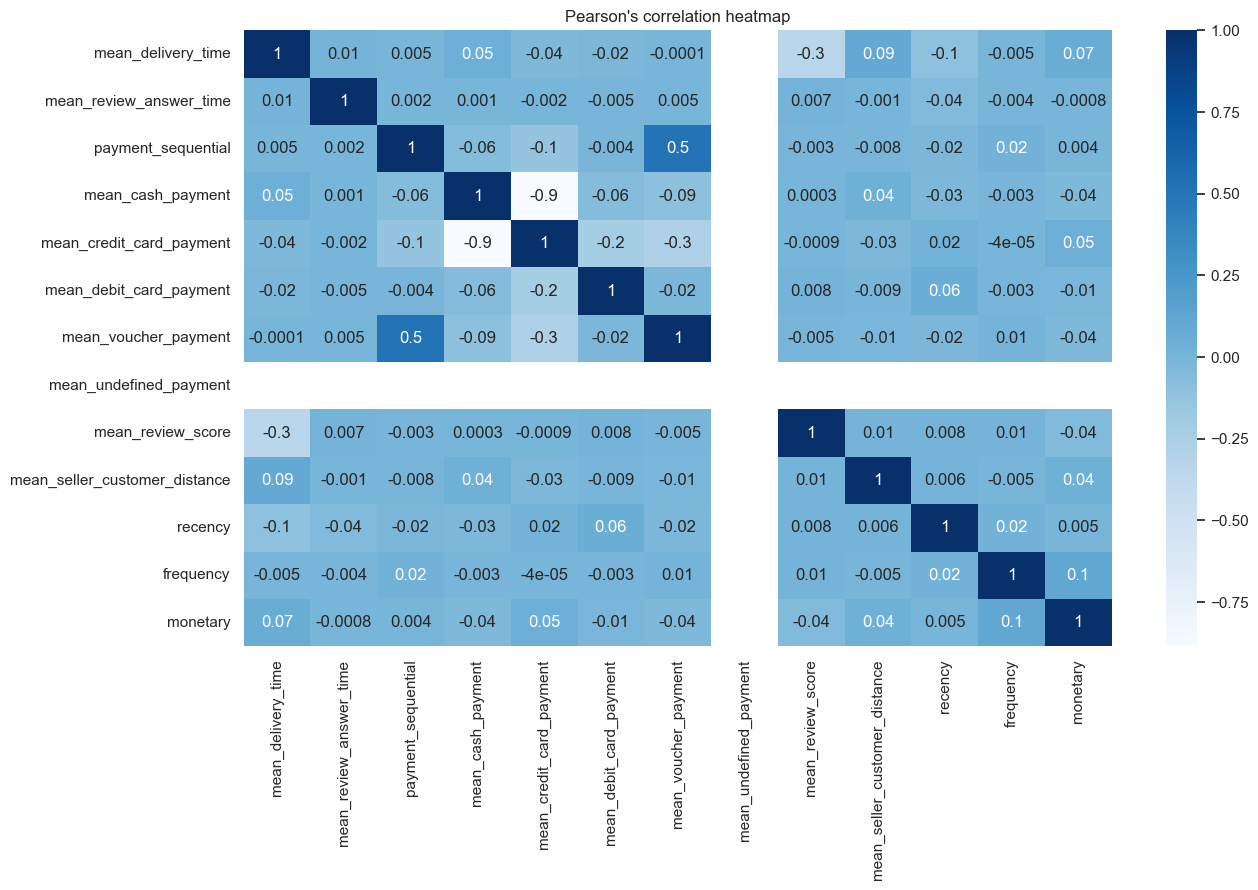

In [41]:
plt.figure(figsize = (14,8))
sns.set_theme(style = "white")
corr = groupeddf.corr(method = 'pearson')

heatmap = sns.heatmap(corr,
                      annot = True,
                      cmap = "Blues",
                      fmt = '.1g')

heatmap.set(title = "Pearson's correlation heatmap")

[Text(0.5, 1.0, 'recency')]

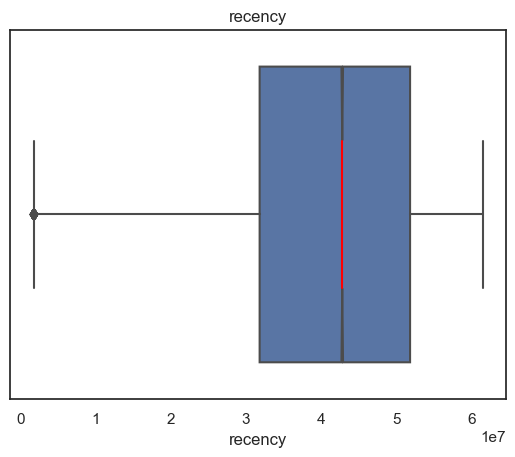

In [42]:
boxplot = sns.boxplot(data = groupeddf,
                      x = "recency",
                      notch = True,
                      medianprops = {"color": "red"})

boxplot.set(title = 'recency')

[Text(0.5, 1.0, 'frequency')]

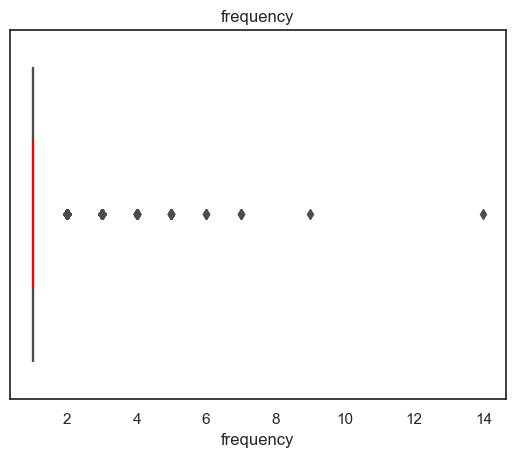

In [43]:
boxplot = sns.boxplot(data = groupeddf,
                      x = "frequency",
                      notch = True,
                      medianprops = {"color": "red"})

boxplot.set(title = 'frequency')

[Text(0.5, 1.0, 'monetary')]

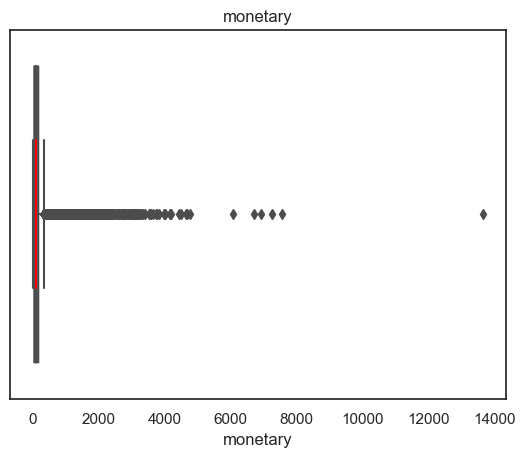

In [44]:
boxplot = sns.boxplot(data = groupeddf,
                      x = "monetary",
                      notch = True,
                      medianprops = {"color": "red"})

boxplot.set(title ='monetary')

[Text(0.5, 1.0, 'mean_delivery_time')]

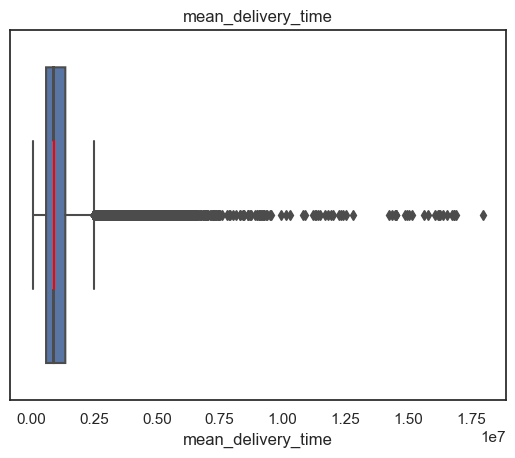

In [45]:
boxplot = sns.boxplot(data = groupeddf,
                      x = "mean_delivery_time",
                      notch = True,
                      medianprops = {"color": "red"})

boxplot.set(title='mean_delivery_time')

[Text(0.5, 1.0, 'mean_review_answer_time')]

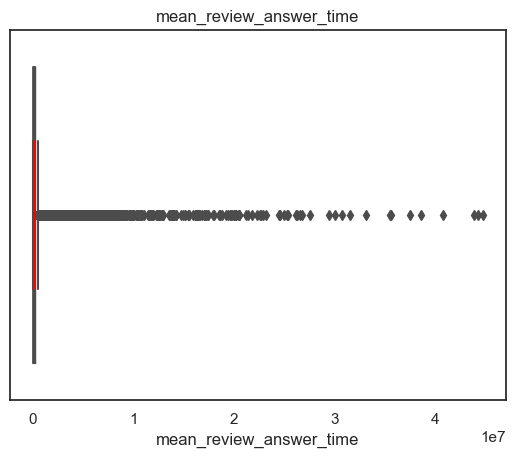

In [46]:
boxplot = sns.boxplot(data=groupeddf,
                      x = "mean_review_answer_time",
                      notch = True,
                      medianprops = {"color": "red"})

boxplot.set(title='mean_review_answer_time')

[Text(0.5, 1.0, 'review_comment_message_number')]

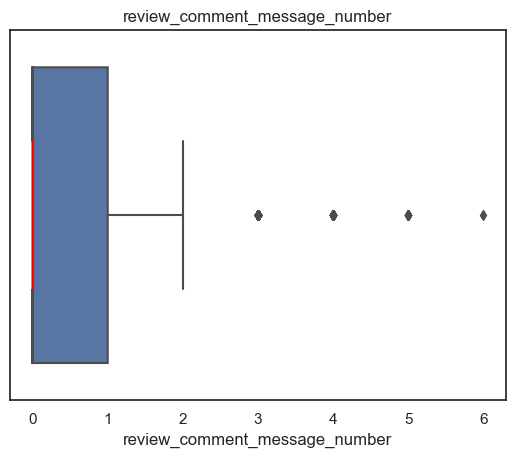

In [47]:
boxplot = sns.boxplot(data = groupeddf,
                      x = "review_comment_message_number",
                      notch = True,
                      medianprops = {"color": "red"})

boxplot.set(title = 'review_comment_message_number')

[Text(0.5, 1.0, 'payment_sequential')]

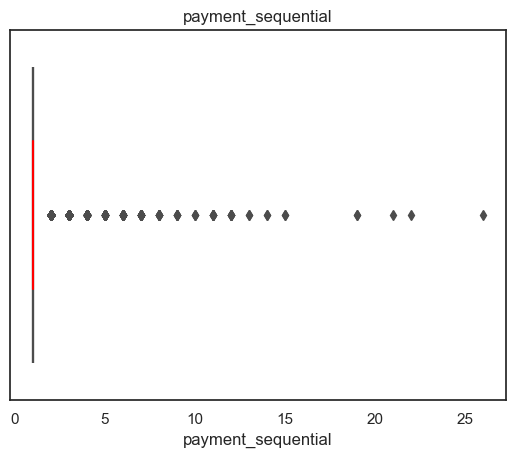

In [48]:
boxplot = sns.boxplot(data = groupeddf,
                      x = "payment_sequential",
                      notch = True,
                      medianprops = {"color": "red"})

boxplot.set(title='payment_sequential')

Normalising data :

In [49]:
#saving unscaled data for futur references
refgroupeddf = groupeddf.copy()

#unscaled data from seconds to days
refgroupeddf["recency"] = refgroupeddf["recency"]/(60*60*24)
refgroupeddf["mean_review_answer_time"] = refgroupeddf["mean_review_answer_time"]/(60*60*24)
refgroupeddf["mean_delivery_time"] = refgroupeddf["mean_delivery_time"]/(60*60*24)


#scaling data
scaler = StandardScaler()

numericol = ['mean_delivery_time',
             'mean_review_answer_time',
             'review_comment_message_number',
             'payment_sequential',
             'mean_cash_payment',
             'mean_credit_card_payment',
             'mean_debit_card_payment',
             'mean_voucher_payment',
             'mean_undefined_payment',
             'mean_seller_customer_distance',
             'mean_review_score',
             'recency',
             'frequency',
             'monetary']

groupeddf.loc[:,numericol] = scaler.fit_transform(groupeddf[numericol])


In [50]:
groupeddf

,mean_delivery_time,mean_review_answer_time,review_comment_message_number,payment_sequential,mean_cash_payment,mean_credit_card_payment,mean_debit_card_payment,mean_voucher_payment,mean_undefined_payment,mean_review_score,customer_city_mostfrequent,customer_state_mostfrequent,seller_city_mostfrequent,seller_state_mostfrequent,product_category_name_mostfrequent,mean_seller_customer_distance,recency,frequency,monetary
customer_unique_id,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.645648,0.144298,1.109844,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,0.660843,cajamar,SP,piracicaba,SP,bed_bath_table,-0.076934,0.821999,-0.159188,-0.102842
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.976334,-0.226073,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,-0.121110,osasco,SP,sao paulo,SP,health_beauty,-0.269384,0.802413,-0.159188,-0.612386
0000f46a3911fa3c0805444483337064,1.398429,-0.214024,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,-0.903062,sao jose,SC,campo limpo paulista,SP,stationery,0.189587,-1.966107,-0.159188,-0.350173
0000f6ccb0745a6a4b88665a16c9f078,0.795943,-0.218402,1.109844,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,-0.121110,belem,PA,sao paulo,SP,telephony,2.364572,-0.551177,-0.159188,-0.539403
0004aac84e0df4da2b147fca70cf8255,0.066364,0.181424,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,0.660843,sorocaba,SP,jacarei,SP,telephony,-0.081250,-0.335182,-0.159188,0.141424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1.587078,0.134061,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,0.660843,sanharo,PE,sao paulo,SP,health_beauty,-0.678507,-1.376506,-0.159188,8.450347
fffea47cd6d3cc0a88bd621562a9d061,1.860316,0.238188,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,-0.121110,feira de santana,BA,laranjal paulista,SP,baby,-0.910643,-0.164746,-0.159188,-0.357458
ffff371b4d645b6ecea244b27531430a,0.249495,-0.053887,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,0.660843,sinop,MT,belo horizonte,MG,auto,2.900129,-2.170636,-0.159188,-0.233615


In [51]:
refgroupeddf

,mean_delivery_time,mean_review_answer_time,review_comment_message_number,payment_sequential,mean_cash_payment,mean_credit_card_payment,mean_debit_card_payment,mean_voucher_payment,mean_undefined_payment,mean_review_score,customer_city_mostfrequent,customer_state_mostfrequent,seller_city_mostfrequent,seller_state_mostfrequent,product_category_name_mostfrequent,mean_seller_customer_distance,recency,frequency,monetary
customer_unique_id,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,6.411227,4.572778,1,1.0,0.0,1.0,0.0,0.0,0.0,5.0,cajamar,SP,piracicaba,SP,bed_bath_table,2.469628e+06,601.944317,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,3.285590,0.937095,0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,osasco,SP,sao paulo,SP,health_beauty,2.376916e+06,598.954734,1,27.19
0000f46a3911fa3c0805444483337064,25.731759,1.055370,0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,sao jose,SC,campo limpo paulista,SP,stationery,2.598022e+06,176.366956,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,20.037083,1.012396,1,1.0,0.0,1.0,0.0,0.0,0.0,4.0,belem,PA,sao paulo,SP,telephony,3.645807e+06,392.342396,1,43.62
0004aac84e0df4da2b147fca70cf8255,13.141134,4.937211,0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,sorocaba,SP,jacarei,SP,telephony,2.467548e+06,425.311852,1,196.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,27.514861,4.472280,0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,sanharo,PE,sao paulo,SP,health_beauty,2.179824e+06,266.363866,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,30.097500,5.494433,0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,feira de santana,BA,laranjal paulista,SP,baby,2.067994e+06,451.327292,1,84.58
ffff371b4d645b6ecea244b27531430a,14.872083,2.627326,0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,sinop,MT,belo horizonte,MG,auto,3.903808e+06,145.147662,1,112.46


PCA analysis (unfruitfull) :

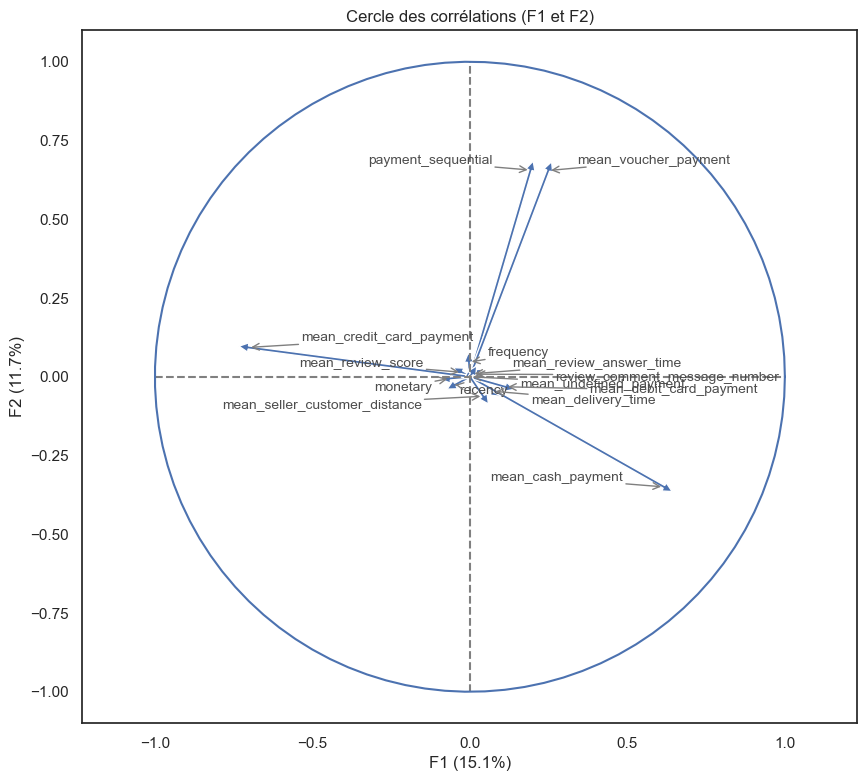

In [52]:
colsubset = ["recency",
             "frequency",
             "monetary",
             "mean_delivery_time",
             "mean_review_score",
             "review_comment_message_number",
             "payment_sequential",
             "mean_cash_payment",
             "mean_credit_card_payment",
             "mean_debit_card_payment",
             "mean_voucher_payment",
             "mean_undefined_payment",
             "mean_review_answer_time",
             "mean_seller_customer_distance"]

#PCA
from sklearn.decomposition import PCA
n_components = groupeddf[colsubset].select_dtypes(include = np.number).shape[1]
pca = PCA(n_components=n_components)
reduced = pca.fit(groupeddf[colsubset])
from adjustText import adjust_text

def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y = x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize = (10, 9))

    TEXTS = []
    GREY50 = "#7F7F7F"
    GREY30 = "#4d4d4d"
    
    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width = 0.03,
                head_length = 0.03, 
                width = 0.01, )
    
        # Les labels
        TEXTS.append(ax.text(pca.components_[x, i],
                             pca.components_[y, i],
                             features[i],
                             color=GREY30,
                             fontsize=10))
    
    adjust_text(
    TEXTS, 
    expand_points = (2, 2),
    arrowprops = dict(
        arrowstyle = "->", 
        color = GREY50, 
        lw = 1
    ),
    ax = fig.axes[0]
)
    
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1],
             [0, 0],
             color = 'grey',
             ls = '--')
    
    plt.plot([0, 0],
             [-1, 1],
             color = 'grey',
             ls = '--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block = False)


correlation_graph(pca,
                  (0,1),
                  colsubset)

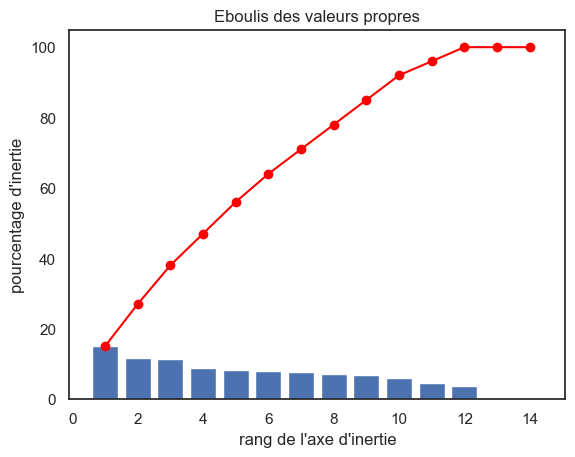

In [53]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)
plt.bar(x_list, scree)

plt.plot(x_list,
         scree_cum,
         c = "red",
         marker = 'o')

plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Text(0.5, 1.0, 'Heatmap des composantes')

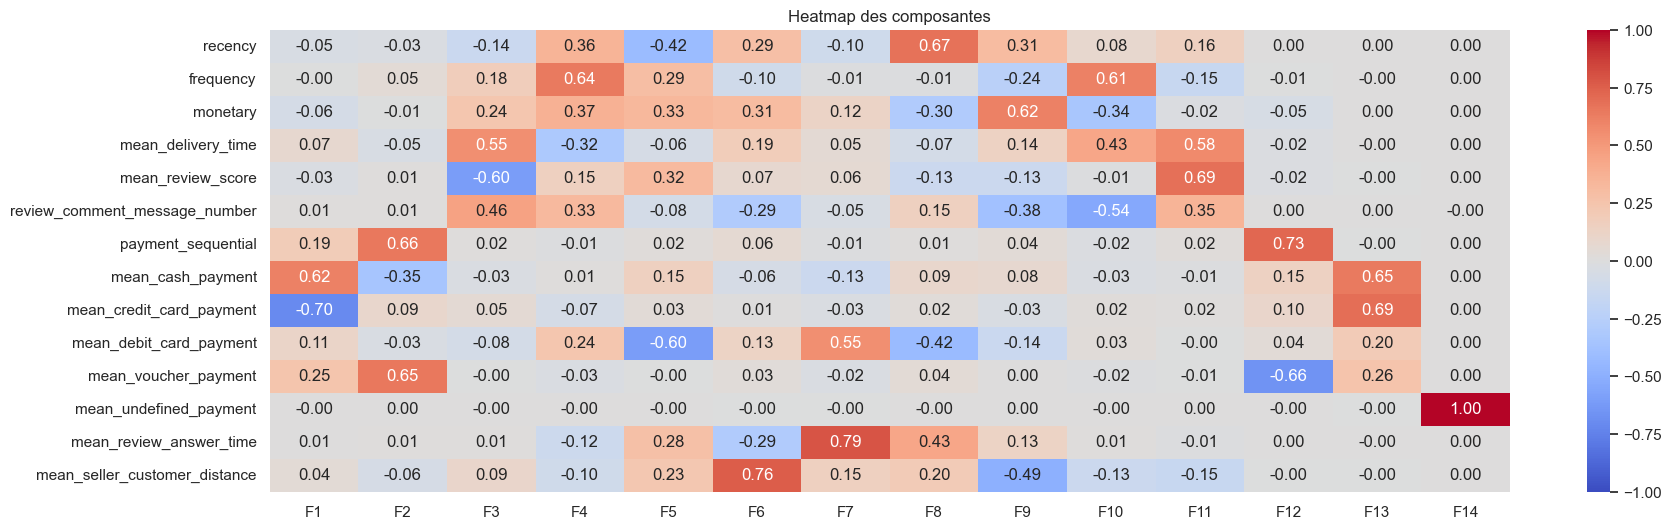

In [54]:
features = colsubset
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
fig, ax = plt.subplots(figsize = (20, 6))

sns.heatmap(pcs.T,
            vmin = -1,
            vmax = 1,
            annot = True,
            cmap = "coolwarm",
            fmt = "0.2f")

plt.title("Heatmap des composantes")

In [55]:
#Projection of data
X_proj = pca.transform(groupeddf[colsubset])
x_list = range(1, n_components+1)
dff= pd.DataFrame(data = X_proj,columns = [f"F{i}" for i in x_list]) 

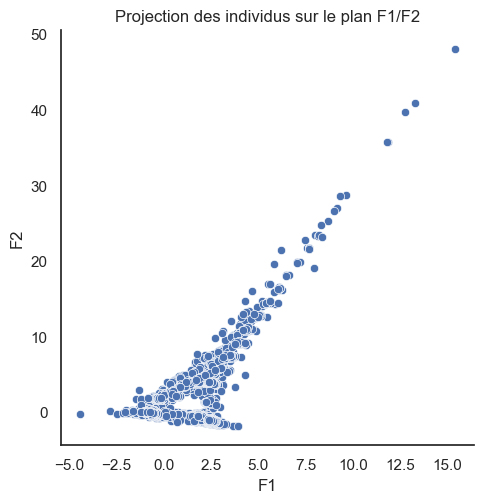

In [56]:
sns.relplot(data = dff,
            x = "F1",
            y = "F2"
           ).set(title = "Projection des individus sur le plan F1/F2")


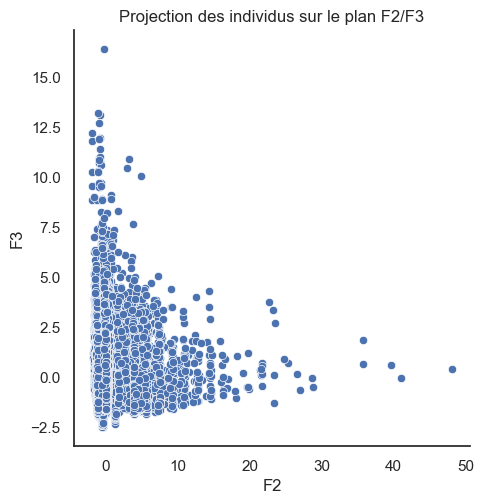

In [57]:
sns.relplot(data = dff,
            x = "F2",
            y = "F3"
           ).set(title = "Projection des individus sur le plan F2/F3")


In [58]:
#saving datasets    
groupeddf.to_csv(os.path.join(PATH, "groupeddf.csv"),
                 encoding = 'utf8',
                 sep = ',')

refgroupeddf.to_csv(os.path.join(PATH, "refgroupeddf.csv"),
                    encoding = 'utf8',
                    sep = ',')